# 4  The Relation Between Runs and Wins


In [1]:
import polars as pl
from plotnine import *

In [48]:
teams = pl.read_csv('data/lahman/lahman_1871-2023/Teams.csv')

In [49]:
teams.tail()

yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
i64,str,str,str,str,i64,i64,str,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,str,str,str,i64,i64,str,str,str
2023,"""NL""","""PIT""","""PIT""","""C""",4,162,"""81""",76,86,"""N""","""N""","""N""","""N""",692,5406,1293,287,31,159,556,1464,117,41,"""58""","""43""",790,731,4.6,2,2,47,4290,1380,179,596,1363,91,360,0.984,"""Pittsburgh Pir…","""PNC Park""","""1630624""",99,101,"""PIT""","""PIT""","""PIT"""
2023,"""NL""","""SDN""","""SDP""","""W""",3,162,"""81""",82,80,"""N""","""N""","""N""","""N""",752,5401,1316,273,14,205,653,1311,137,32,"""57""","""44""",648,598,3.73,0,0,36,4323,1270,174,557,1445,73,356,0.988,"""San Diego Padr…","""PETCO Park""","""3271554""",94,93,"""SDP""","""SDN""","""SDN"""
2023,"""NL""","""SFN""","""SFG""","""W""",4,162,"""81""",79,83,"""N""","""N""","""N""","""N""",674,5412,1271,256,13,174,544,1492,57,16,"""81""","""39""",719,641,4.02,4,2,50,4304,1395,173,403,1359,117,399,0.981,"""San Francisco …","""AT&T Park""","""2500153""",96,96,"""SFG""","""SFN""","""SFN"""
2023,"""NL""","""SLN""","""STL""","""C""",5,162,"""81""",71,91,"""N""","""N""","""N""","""N""",719,5510,1376,264,12,209,570,1326,101,29,"""70""","""37""",829,760,4.79,0,0,36,4285,1549,179,530,1215,67,431,0.989,"""St. Louis Card…","""Busch Stadium …","""3241091""",99,99,"""STL""","""SLN""","""SLN"""
2023,"""NL""","""WAS""","""WSN""","""E""",5,162,"""81""",71,91,"""N""","""N""","""N""","""N""",700,5522,1401,279,26,151,423,1149,127,29,"""78""","""38""",845,797,5.02,0,0,42,4285,1512,245,592,1225,90,430,0.985,"""Washington Nat…","""Nationals Park…","""1865832""",96,98,"""WSN""","""MON""","""WAS"""


In [50]:
my_teams = (
    teams
    .filter(pl.col('yearID')>2000)
    .select('teamID', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA')
    .with_columns(
        RD=pl.col('R') - pl.col('RA'),
        Wpct=pl.col('W') / (pl.col('W') + pl.col('L'))
    )
)

my_teams.tail()

teamID,yearID,lgID,G,W,L,R,RA,RD,Wpct
str,i64,str,i64,i64,i64,i64,i64,i64,f64
"""PIT""",2023,"""NL""",162,76,86,692,790,-98,0.469136
"""SDN""",2023,"""NL""",162,82,80,752,648,104,0.506173
"""SFN""",2023,"""NL""",162,79,83,674,719,-45,0.487654
"""SLN""",2023,"""NL""",162,71,91,719,829,-110,0.438272
"""WAS""",2023,"""NL""",162,71,91,700,845,-145,0.438272


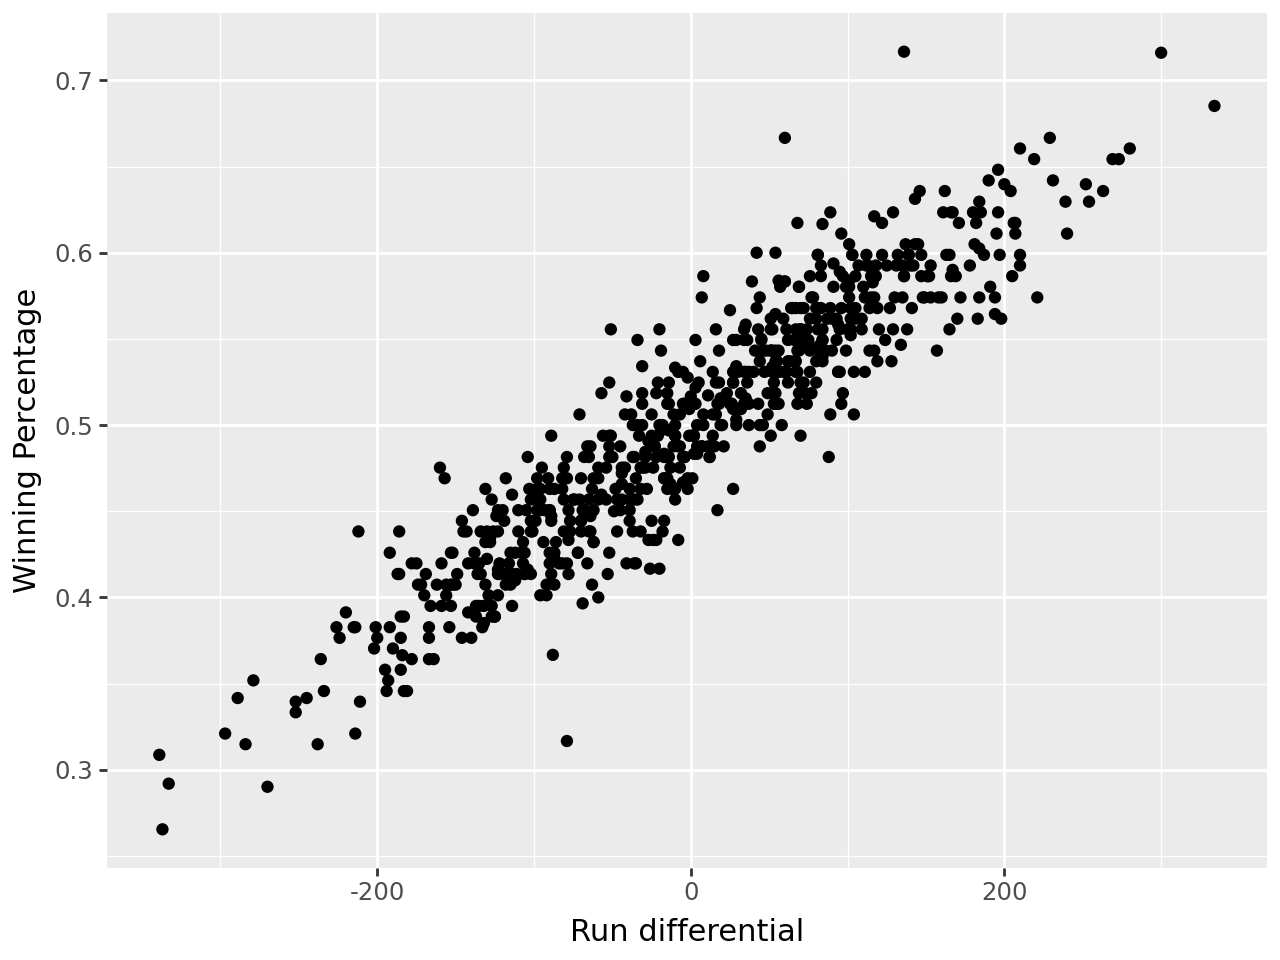

In [51]:
run_diff = (
    ggplot(my_teams, aes(x='RD', y='Wpct')) 
    + geom_point() 
    + xlab('Run differential') 
    + ylab('Winning Percentage')
)

run_diff

In [52]:
import statsmodels.api as sm

y = my_teams.select('Wpct').to_numpy()
x = my_teams.select('RD').to_numpy()

model = sm.OLS(y, sm.add_constant(x))
linfit = model.fit()

linfit.summary(), linfit.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.864
 Model:                            OLS   Adj. R-squared:                  0.863
 Method:                 Least Squares   F-statistic:                     4354.
 Date:                Fri, 10 May 2024   Prob (F-statistic):          9.08e-300
 Time:                        14:52:10   Log-Likelihood:                 1487.8
 No. Observations:                 690   AIC:                            -2972.
 Df Residuals:                     688   BIC:                            -2962.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

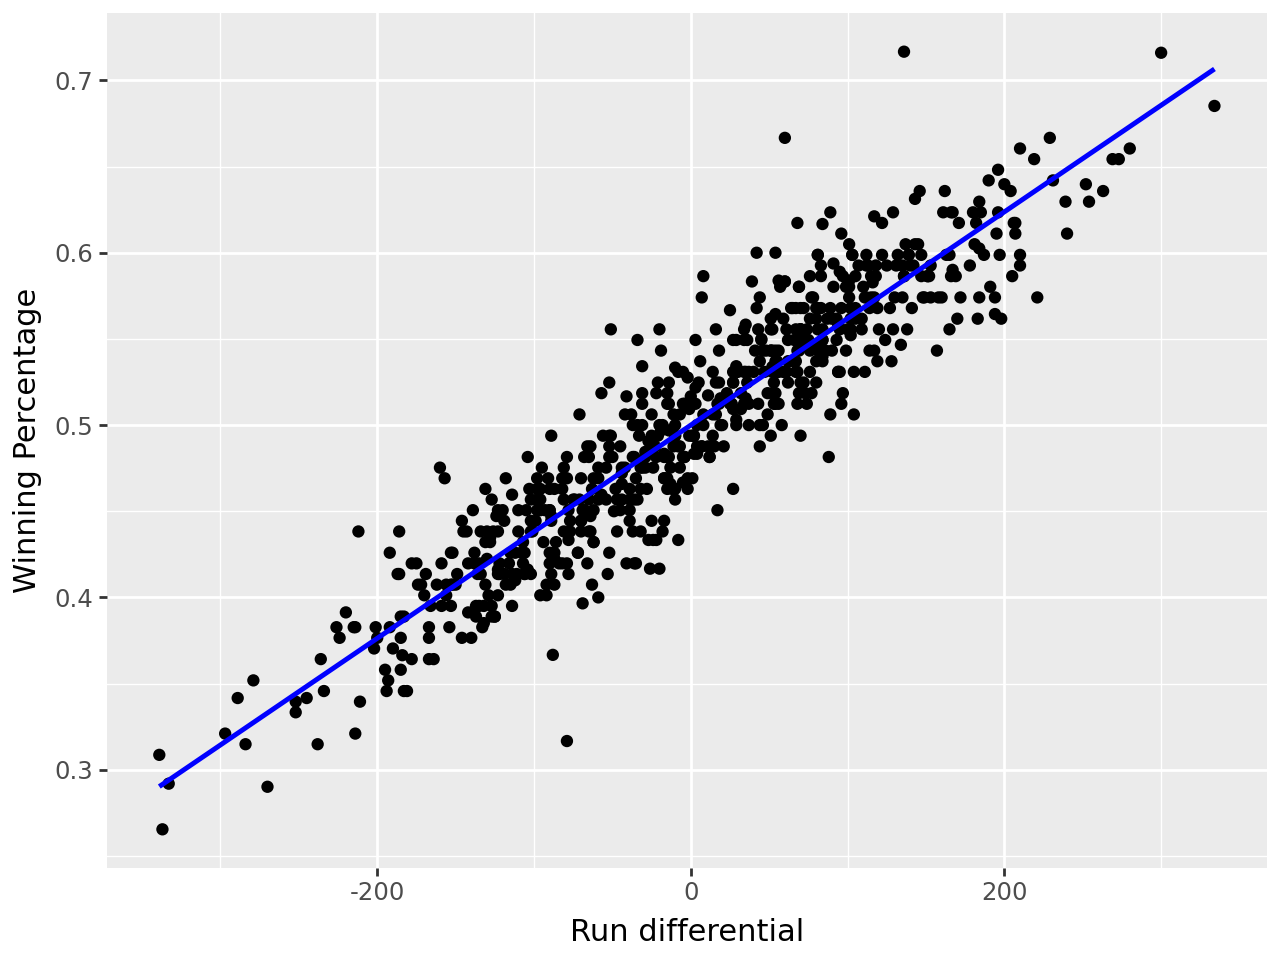

In [53]:
(
    run_diff + 
    geom_smooth(method='lm', se=False, color='blue')
)

In [54]:
my_teams_aug = (
    my_teams
    .with_columns(
        pl.from_numpy(linfit.resid).to_series().alias('Resid')
    )
)

In [55]:
base_plot = (
    ggplot(my_teams_aug, aes(x='RD', y='Resid'))
    + geom_point(alpha=0.3)
    + geom_hline(yintercept=0, linetype='dashed')
    + xlab('Run differential') + ylab('Residual')
)

In [56]:
highlight_teams = (
    my_teams_aug
    .sort(abs(pl.col('Resid')), descending=True)
    .head(4)
)

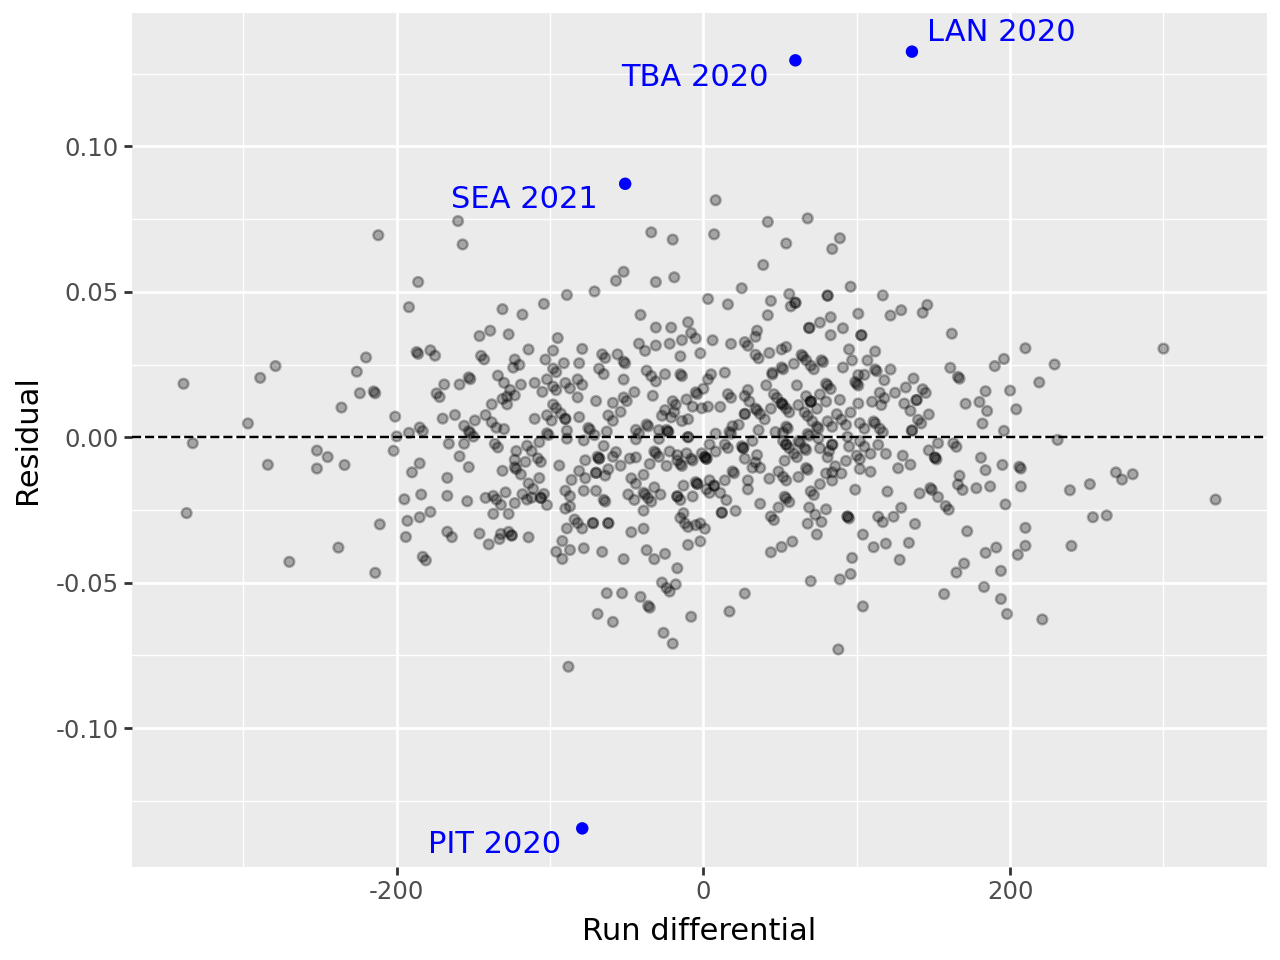

In [57]:
(
    base_plot 
    + geom_point(data=highlight_teams, color='blue') 
    + geom_text(
        data=highlight_teams, color='blue',
        label=highlight_teams['teamID'] + ' ' + highlight_teams['yearID'],
        adjust_text={
            'expand': (1.5, 1),
            'min_arrow_len': 100
        }, 
    )
)

In [12]:
resid_summary = (
    my_teams_aug
    .select(
        N=pl.len(),
        avg=pl.col('Resid').mean(),
        RMSE=(pl.col('Resid')**2).mean().sqrt()
    )
)

In [13]:
rmse = resid_summary.select('RMSE')[0,0]
rmse

0.0280118940147399

In [14]:
(
    my_teams_aug
    .select(
        N=pl.len(),
        within_one=(pl.col('Resid').abs() < rmse).sum(),
        within_two=(pl.col('Resid').abs() < rmse*2).sum()
    )
    .with_columns(
        within_one_pct=pl.col('within_one') / pl.col('N'),
        within_two_pct=pl.col('within_two') / pl.col('N')
    )
)

N,within_one,within_two,within_one_pct,within_two_pct
u32,u32,u32,f64,f64
690,497,659,0.72029,0.955072


In [15]:
my_teams = (
    my_teams
    .with_columns(
        Wpct_pyt=pl.col('R')**2 / (pl.col('R')**2 + pl.col('RA')**2)
    )
)
my_teams.head()

teamID,yearID,lgID,G,W,L,R,RA,RD,Wpct,Wpct_pyt
str,i64,str,i64,i64,i64,i64,i64,i64,f64,f64
"""ANA""",2001,"""AL""",162,75,87,691,730,-39,0.462963,0.472575
"""BAL""",2001,"""AL""",162,63,98,687,829,-142,0.391304,0.407147
"""BOS""",2001,"""AL""",161,82,79,772,745,27,0.509317,0.517793
"""CHA""",2001,"""AL""",162,83,79,798,795,3,0.512346,0.501883
"""CLE""",2001,"""AL""",162,91,71,897,821,76,0.561728,0.544151


In [16]:
(
    my_teams
    .with_columns(residuals_pyt=pl.col('Wpct') - pl.col('Wpct_pyt'))
    .select(
        rmse=(pl.col('residuals_pyt')**2).mean().sqrt()
    )
)

rmse
f64
0.026644


In [18]:
my_teams = (
    my_teams
    .with_columns(
        logWratio=(pl.col('W') / pl.col('L')).log(),
        logRratio=(pl.col('R') / pl.col('RA')).log()
    )
)
my_teams.head()

teamID,yearID,lgID,G,W,L,R,RA,RD,Wpct,Wpct_pyt,logWratio,logRratio
str,i64,str,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64
"""ANA""",2001,"""AL""",162,75,87,691,730,-39,0.462963,0.472575,-0.14842,-0.054905
"""BAL""",2001,"""AL""",162,63,98,687,829,-142,0.391304,0.407147,-0.441833,-0.187886
"""BOS""",2001,"""AL""",161,82,79,772,745,27,0.509317,0.517793,0.037271,0.0356
"""CHA""",2001,"""AL""",162,83,79,798,795,3,0.512346,0.501883,0.049393,0.003766
"""CLE""",2001,"""AL""",162,91,71,897,821,76,0.561728,0.544151,0.24818,0.088533


In [26]:
import statsmodels.formula.api as smf

model = smf.ols('logWratio ~ 0 + logRratio', data=my_teams)
pyt_fit = model.fit()

pyt_fit.summary(), pyt_fit.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                  OLS Regression Results                                
 Dep. Variable:              logWratio   R-squared (uncentered):                   0.883
 Model:                            OLS   Adj. R-squared (uncentered):              0.883
 Method:                 Least Squares   F-statistic:                              5217.
 Date:                Fri, 10 May 2024   Prob (F-statistic):                   9.88e-324
 Time:                        14:14:36   Log-Likelihood:                          570.66
 No. Observations:                 690   AIC:                                     -1139.
 Df Residuals:                     689   BIC:                                     -1135.
 Df Model:                           1                                                  
 Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|     

In [31]:
gl2011 = pl.read_csv('data/retrosheet/parsed/games2011.csv', try_parse_dates=True, dtypes={'AWAY_LINE_TX': pl.Utf8})
gl2011.head()

GAME_ID,GAME_DT,GAME_CT,GAME_DY,START_GAME_TM,DH_FL,DAYNIGHT_PARK_CD,AWAY_TEAM_ID,HOME_TEAM_ID,PARK_ID,AWAY_START_PIT_ID,HOME_START_PIT_ID,BASE4_UMP_ID,BASE1_UMP_ID,BASE2_UMP_ID,BASE3_UMP_ID,LF_UMP_ID,RF_UMP_ID,ATTEND_PARK_CT,SCORER_RECORD_ID,TRANSLATOR_RECORD_ID,INPUTTER_RECORD_ID,INPUT_RECORD_TS,EDIT_RECORD_TS,METHOD_RECORD_CD,PITCHES_RECORD_CD,TEMP_PARK_CT,WIND_DIRECTION_PARK_CD,WIND_SPEED_PARK_CT,FIELD_PARK_CD,PRECIP_PARK_CD,SKY_PARK_CD,MINUTES_GAME_CT,INN_CT,AWAY_SCORE_CT,HOME_SCORE_CT,AWAY_HITS_CT,…,HOME_DP_CT,HOME_TP_CT,UMP_HOME_NAME_TX,UMP_1B_NAME_TX,UMP_2B_NAME_TX,UMP_3B_NAME_TX,UMP_LF_NAME_TX,UMP_RF_NAME_TX,AWAY_MANAGER_ID,AWAY_MANAGER_NAME_TX,HOME_MANAGER_ID,HOME_MANAGER_NAME_TX,WIN_PIT_NAME_TX,LOSE_PIT_NAME_TX,SAVE_PIT_NAME_TX,GOAHEAD_RBI_ID,GOAHEAD_RBI_NAME_TX,AWAY_LINEUP1_BAT_NAME_TX,AWAY_LINEUP2_BAT_NAME_TX,AWAY_LINEUP3_BAT_NAME_TX,AWAY_LINEUP4_BAT_NAME_TX,AWAY_LINEUP5_BAT_NAME_TX,AWAY_LINEUP6_BAT_NAME_TX,AWAY_LINEUP7_BAT_NAME_TX,AWAY_LINEUP8_BAT_NAME_TX,AWAY_LINEUP9_BAT_NAME_TX,HOME_LINEUP1_BAT_NAME_TX,HOME_LINEUP2_BAT_NAME_TX,HOME_LINEUP3_BAT_NAME_TX,HOME_LINEUP4_BAT_NAME_TX,HOME_LINEUP5_BAT_NAME_TX,HOME_LINEUP6_BAT_NAME_TX,HOME_LINEUP7_BAT_NAME_TX,HOME_LINEUP8_BAT_NAME_TX,HOME_LINEUP9_BAT_NAME_TX,ADD_INFO_TX,ACQ_INFO_TX
str,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ANA201104080""",20110408,0,"""Friday""",707,"""T""","""N""","""TOR""","""ANA""","""ANA01""","""drabk001""","""sante001""","""davib902""","""wendh902""","""knigb901""","""laynj901""","""""","""""",43853,"""""","""""","""""","""""","""""",1,1,54,2,9,0,0,0,155,9,3,2,7,…,1,0,null,null,null,null,null,null,null,null,null,null,"""Octavio Dotel""","""Ervin Santana""","""Jon Rauch""","""nix-j001""","""Jayson Nix""","""Rajai Davis""","""Jayson Nix""","""Jose Bautista""","""Adam Lind""","""Aaron Hill""","""Juan Rivera""","""Travis Snider""","""Jose Molina""","""John McDonald""","""Maicer Izturis…","""Howie Kendrick…","""Bobby Abreu""","""Torii Hunter""","""Vernon Wells""","""Alberto Callas…","""Mark Trumbo""","""Hank Conger""","""Peter Bourjos""",null,null
"""ANA201104090""",20110409,0,"""Saturday""",607,"""T""","""N""","""TOR""","""ANA""","""ANA01""","""cecib001""","""palmm001""","""wendh902""","""knigb901""","""laynj901""","""davib902""","""""","""""",43513,"""""","""""","""""","""""","""""",1,1,56,2,11,0,0,0,303,14,5,6,13,…,0,0,null,null,null,null,null,null,null,null,null,null,"""Dan Haren""","""Jon Rauch""","""(none)""","""iztum001""","""Maicer Izturis…","""Rajai Davis""","""Aaron Hill""","""Jose Bautista""","""Adam Lind""","""Juan Rivera""","""J.P. Arencibia…","""Travis Snider""","""Edwin Encarnac…","""John McDonald""","""Maicer Izturis…","""Howie Kendrick…","""Bobby Abreu""","""Torii Hunter""","""Vernon Wells""","""Alberto Callas…","""Mark Trumbo""","""Jeff Mathis""","""Peter Bourjos""",null,null
"""ANA201104100""",20110410,0,"""Sunday""",1236,"""T""","""D""","""TOR""","""ANA""","""ANA01""","""reyej003""","""weavj003""","""knigb901""","""laynj901""","""davib902""","""wendh902""","""""","""""",43525,"""""","""""","""""","""""","""""",1,1,62,3,5,0,0,1,168,9,1,3,4,…,0,0,null,null,null,null,null,null,null,null,null,null,"""Jered Weaver""","""Jo-Jo Reyes""","""Fernando Rodne…","""huntt001""","""Torii Hunter""","""Rajai Davis""","""Yunel Escobar""","""Jose Bautista""","""Adam Lind""","""Aaron Hill""","""Juan Rivera""","""Travis Snider""","""Jayson Nix""","""Jose Molina""","""Peter Bourjos""","""Howie Kendrick…","""Bobby Abreu""","""Torii Hunter""","""Vernon Wells""","""Alberto Callas…","""Mark Trumbo""","""Bobby Wilson""","""Brandon Wood""",null,null
"""ANA201104110""",20110411,0,"""Monday""",707,"""T""","""N""","""CLE""","""ANA""","""ANA01""","""talbm001""","""chatt001""","""mcclt901""","""barrt901""","""run

In [41]:
box2011 = (
    gl2011
    .filter(
        (pl.col('HOME_TEAM_ID')=='BOS') 
        | (pl.col('AWAY_TEAM_ID')=='BOS')
    )
    .select(
        'AWAY_TEAM_ID', 'HOME_TEAM_ID', 'AWAY_SCORE_CT', 'HOME_SCORE_CT'
    )
)
box2011.head()

AWAY_TEAM_ID,HOME_TEAM_ID,AWAY_SCORE_CT,HOME_SCORE_CT
str,str,i64,i64
"""BOS""","""ANA""",4,2
"""BOS""","""ANA""",4,3
"""BOS""","""ANA""",5,0
"""BOS""","""ANA""",7,0
"""BOS""","""BAL""",1,4
